# OVERVIEW
- feature engineering conventions
- tricks with pandas (groupby, stack-unstack, merge, playing with dates) 
- time series features(trends, aggregations by different dates...)
- dealing with categorical features (label encoding ...)
- further exploration during feature engineering
- feature selection
- transformations (scaling)
- dealing with missing values

# RESTAURANT - Feature Engineering and Feature Selection

In [1]:
from scipy import stats
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
from scipy import stats
import warnings
from statsmodels.tsa.stattools import adfuller
from IPython.display import Image
import logging
from fbprophet import Prophet
import warnings
warnings.simplefilter('ignore')
import multiprocessing
from multiprocessing import Pool

warnings.simplefilter('ignore')

In [2]:
from sklearn import preprocessing

In [3]:
# global vars
# plt.rcParams.keys()
plt.rcParams['grid.linestyle'] ='--'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['figure.figsize'] = [7,3]
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.titleweight"] = "bold"

sns.set_palette("PRGn", 10)

In [4]:
%matplotlib inline

In [5]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# IMPORT DATA

In [6]:
path_input = ('../input/')

In [7]:
air_visits = pd.read_csv(os.path.join(path_input,'air_visit_data.csv.gz'))
air_reserve = pd.read_csv(os.path.join(path_input,'air_reserve.csv.gz'))
hpg_reserve = pd.read_csv(os.path.join(path_input,'hpg_reserve.csv.gz'))
air_store = pd.read_csv(os.path.join(path_input,'air_store_info.csv.gz'))
hpg_store = pd.read_csv(os.path.join(path_input,'hpg_store_info.csv.gz'))
holidays = pd.read_csv(os.path.join(path_input,'date_info.csv.gz'))
store_ids = pd.read_csv(os.path.join(path_input,'store_id_relation.csv.gz'))
submission = pd.read_csv(os.path.join(path_input,'sample_submission.csv.gz'))

In [9]:
print(air_visits.shape)
print(air_reserve.shape)
print(hpg_reserve.shape)
print(air_store.shape)
print(hpg_store.shape)
print(holidays.shape)
print(store_ids.shape)
print(submission.shape)

(252108, 3)
(92378, 4)
(2000320, 4)
(829, 5)
(4690, 5)
(517, 3)
(150, 2)
(32019, 2)


# Feature engineering

#### Feature engineering steps:

create a seperate dataframe for feature enginnering (say train and test)

for each feature:
- create feature
- rename columns
- merge on train test dfs

In [10]:
train = air_visits.copy()
test = submission.copy()

In [11]:
train['visit_date'] = pd.to_datetime(train['visit_date'])
train['dow'] = train['visit_date'].dt.dayofweek
train['year'] = train['visit_date'].dt.year
train['month'] = train['visit_date'].dt.month
train['visit_date'] = train['visit_date'].dt.date

test['visit_date'] = test['id'].map(lambda x: str(x).split('_')[2])
test['air_store_id'] = test['id'].map(lambda x: '_'.join(x.split('_')[:2]))
test['visit_date'] = pd.to_datetime(test['visit_date'])
test['dow'] = test['visit_date'].dt.dayofweek
test['year'] = test['visit_date'].dt.year
test['month'] = test['visit_date'].dt.month
test['visit_date'] = test['visit_date'].dt.date

In [12]:
# prediction time window
print(np.min(test.visit_date) , np.max(test.visit_date))

2017-04-23 2017-05-31


    Some restaurants at train dataset does not exit on test

In [13]:
len(set(train['air_store_id'].unique()) - set(test['air_store_id'].unique()))

8

# RESERVATION FEAUTURES

In [14]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['visit_datetime'] = air_reserve['visit_datetime'].dt.date
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['reserve_datetime'] = air_reserve['reserve_datetime'].dt.date
air_reserve['reserve_datetime_diff'] = air_reserve.apply(lambda x: (x['visit_datetime'] - x['reserve_datetime']).days, axis=1)

In [15]:
air_reserve_features = []

aggregations =  ['mean', 'min', 'max', 'sum', 'std', 'median']

gr = air_reserve.groupby(['air_store_id','visit_datetime'], as_index=False)\
[['reserve_datetime_diff', 'reserve_visitors']].agg(aggregations)

gr.columns = ['AIR_RESERVE_{}_{}'.format(e[0],e[1]) for e in gr.columns]

air_reserve_features.extend(gr.columns)

gr = gr.reset_index()

gr = gr.rename(columns={'visit_datetime':'visit_date'})

gr.head(2)

,air_store_id,visit_date,AIR_RESERVE_reserve_datetime_diff_mean,AIR_RESERVE_reserve_datetime_diff_min,AIR_RESERVE_reserve_datetime_diff_max,AIR_RESERVE_reserve_datetime_diff_sum,AIR_RESERVE_reserve_datetime_diff_std,AIR_RESERVE_reserve_datetime_diff_median,AIR_RESERVE_reserve_visitors_mean,AIR_RESERVE_reserve_visitors_min,AIR_RESERVE_reserve_visitors_max,AIR_RESERVE_reserve_visitors_sum,AIR_RESERVE_reserve_visitors_std,AIR_RESERVE_reserve_visitors_median
0,air_00a91d42b08b08d9,2016-10-31,0.0,0,0,0,NaN,0.0,2.0,2,2,2,NaN,2.0
1,air_00a91d42b08b08d9,2016-12-05,4.0,4,4,4,NaN,4.0,9.0,9,9,9,NaN,9.0


    merge on feature engineering dataframes

In [16]:
train = train.merge(gr, how='left', on=['air_store_id','visit_date'])
test = test.merge(gr, how='left', on=['air_store_id','visit_date'])

In [17]:
# sanity check
train[(train.air_store_id=='air_fee8dcf4d619598e')&(train.visit_date == pd.to_datetime('2017-01-09').date())]

,air_store_id,visit_date,visitors,dow,year,month,AIR_RESERVE_reserve_datetime_diff_mean,AIR_RESERVE_reserve_datetime_diff_min,AIR_RESERVE_reserve_datetime_diff_max,AIR_RESERVE_reserve_datetime_diff_sum,AIR_RESERVE_reserve_datetime_diff_std,AIR_RESERVE_reserve_datetime_diff_median,AIR_RESERVE_reserve_visitors_mean,AIR_RESERVE_reserve_visitors_min,AIR_RESERVE_reserve_visitors_max,AIR_RESERVE_reserve_visitors_sum,AIR_RESERVE_reserve_visitors_std,AIR_RESERVE_reserve_visitors_median
35855,air_fee8dcf4d619598e,2017-01-09,17,0,2017,1,8.0,3.0,13.0,16.0,7.071068,8.0,2.5,2.0,3.0,5.0,0.707107,2.5


    do the same for hpg tables

    first, merge hpg_reserve and store_id table to put air_reserve_id info

In [18]:
store_ids.head(2)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809


    how='inner' keep restaurants that only hve both air and hpg ids

In [19]:
hpg_air = pd.merge(hpg_reserve,store_ids,how='inner', on=['hpg_store_id'])

In [20]:
hpg_air.head(2)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926


    but we are losing lots of information since we keep less than 0.02 rows of the hpg_reserves table!

In [21]:
print(hpg_reserve.shape, hpg_air.shape, hpg_air.shape[0]/hpg_reserve.shape[0])

(2000320, 4) (28183, 5) 0.014089245720684691


In [22]:
hpg_air['visit_datetime'] = pd.to_datetime(hpg_air['visit_datetime'])
hpg_air['visit_datetime'] = hpg_air['visit_datetime'].dt.date
hpg_air['reserve_datetime'] = pd.to_datetime(hpg_air['reserve_datetime'])
hpg_air['reserve_datetime'] = hpg_air['reserve_datetime'].dt.date
hpg_air['reserve_datetime_diff'] = hpg_air.apply(lambda x: (x['visit_datetime'] - x['reserve_datetime']).days, axis=1)

In [23]:
hpg_reserve_features = []

aggregations =  ['mean', 'min', 'max', 'sum', 'std', 'median']

gr = hpg_air.groupby(['air_store_id','visit_datetime'], as_index=False)\
[['reserve_datetime_diff', 'reserve_visitors']].agg(aggregations)

gr.columns = ['HPG_RESERVE_{}_{}'.format(e[0],e[1]) for e in gr.columns]

hpg_reserve_features.extend(gr.columns)

gr = gr.reset_index()

gr = gr.rename(columns={'visit_datetime':'visit_date'})

gr.head(2)

,air_store_id,visit_date,HPG_RESERVE_reserve_datetime_diff_mean,HPG_RESERVE_reserve_datetime_diff_min,HPG_RESERVE_reserve_datetime_diff_max,HPG_RESERVE_reserve_datetime_diff_sum,HPG_RESERVE_reserve_datetime_diff_std,HPG_RESERVE_reserve_datetime_diff_median,HPG_RESERVE_reserve_visitors_mean,HPG_RESERVE_reserve_visitors_min,HPG_RESERVE_reserve_visitors_max,HPG_RESERVE_reserve_visitors_sum,HPG_RESERVE_reserve_visitors_std,HPG_RESERVE_reserve_visitors_median
0,air_00a91d42b08b08d9,2016-01-14,3.0,3,3,3,NaN,3.0,2.0,2,2,2,NaN,2.0
1,air_00a91d42b08b08d9,2016-01-15,6.0,6,6,6,NaN,6.0,4.0,4,4,4,NaN,4.0


In [24]:
train = train.merge(gr, how='left', on=['air_store_id','visit_date'])
test = test.merge(gr, how='left', on=['air_store_id','visit_date'])

In [25]:
# train.head()

#### Some aggragations of aggregations

In [26]:
# HPG ve AIR den gelen reservelerin agg featurelari
train['sum_AIR_HPG_reser_visitors_sum'] = train['AIR_RESERVE_reserve_visitors_sum'] + train['HPG_RESERVE_reserve_visitors_sum']# train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
# train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['sum_AIR_HPG_reser_visitors_sum'] = test['AIR_RESERVE_reserve_visitors_sum'] + test['HPG_RESERVE_reserve_visitors_sum']# test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
# test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

#### Merge reserve and visit tables

In [27]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,0
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,0
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,0


In [28]:
air_reserve = air_reserve.rename(columns={'visit_datetime':'visit_date'})

In [29]:
train = pd.merge(train, air_reserve, how='left', on=['air_store_id','visit_date']) 
test = pd.merge(test, air_reserve, how='left', on=['air_store_id','visit_date'])

In [30]:
# train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

#### Problem with reservations

    Mesela en son 05-31 gunu icin 04-22 gununde reservation yapilmis, 
    fakat ondan sonraki gunler icin reservation yok!

In [31]:
print('the last day of reservation time')
print(np.max(air_reserve.reserve_datetime))
print('the last day of visit time')
print(np.max(air_reserve.visit_datetime))

the last day of reservation time
2017-04-22
the last day of visit time


AttributeError: 'DataFrame' object has no attribute 'visit_datetime'

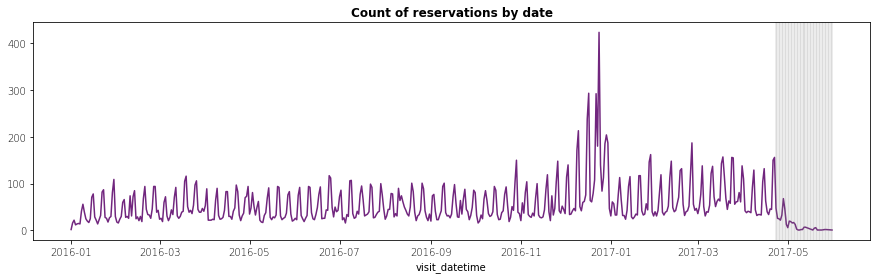

In [32]:
plt.figure(figsize=(15,4))
hpg_air.groupby('visit_datetime')['reserve_visitors'].count().plot()
plt.title('Count of reservations by date')
for x in test['visit_date'].unique():
    _ = plt.axvline(x=x, color='gray', alpha = 0.2);

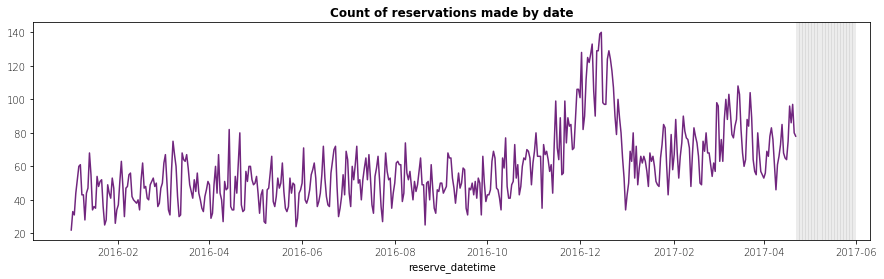

In [33]:
# no reservation info during test time
plt.figure(figsize=(15,4))
hpg_air.groupby('reserve_datetime')['reserve_visitors'].count().plot()
plt.title('Count of reservations made by date')
for x in test['visit_date'].unique():
    _ = plt.axvline(x=x, color='gray', alpha = 0.2);

# STORE FEATURES

## Visitors by stores and days of weeks

In [34]:
unique_stores = test['air_store_id'].unique()
# stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#### How to use unstack

In [35]:
stores_features = []

gr = train.groupby(['air_store_id','dow'])['visitors'].agg(['min','mean','median','max','count',]
                                                          )
gr = gr.unstack(level=-1).fillna(0)

gr.columns = ['STORE_VISITORS_BY_DATE_{}_{}'.format(e[0],e[1]) for e in gr.columns]

stores_features.extend(gr.columns)

gr = gr.reset_index()

gr.head()

,air_store_id,STORE_VISITORS_BY_DATE_min_0,STORE_VISITORS_BY_DATE_min_1,STORE_VISITORS_BY_DATE_min_2,STORE_VISITORS_BY_DATE_min_3,STORE_VISITORS_BY_DATE_min_4,STORE_VISITORS_BY_DATE_min_5,STORE_VISITORS_BY_DATE_min_6,STORE_VISITORS_BY_DATE_mean_0,STORE_VISITORS_BY_DATE_mean_1,...,STORE_VISITORS_BY_DATE_max_4,STORE_VISITORS_BY_DATE_max_5,STORE_VISITORS_BY_DATE_max_6,STORE_VISITORS_BY_DATE_count_0,STORE_VISITORS_BY_DATE_count_1,STORE_VISITORS_BY_DATE_count_2,STORE_VISITORS_BY_DATE_count_3,STORE_VISITORS_BY_DATE_count_4,STORE_VISITORS_BY_DATE_count_5,STORE_VISITORS_BY_DATE_count_6
0,air_00a91d42b08b08d9,1.0,1.0,15.0,15.0,17.0,3.0,2.0,22.457143,24.350000,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0
1,air_0164b9927d20bcc3,2.0,1.0,2.0,1.0,3.0,1.0,0.0,9.969697,10.400000,...,26.0,25.0,0.0,33.0,35.0,39.0,41.0,44.0,23.0,0.0
2,air_0241aa3964b7f861,2.0,1.0,2.0,1.0,1.0,2.0,1.0,8.920635,8.621212,...,48.0,37.0,26.0,63.0,66.0,68.0,9.0,61.0,65.0,64.0
3,air_0328696196e46f18,2.0,2.0,1.0,1.0,1.0,2.0,1.0,6.416667,7.285714,...,19.0,22.0,41.0,12.0,14.0,17.0,17.0,22.0,17.0,17.0
4,air_034a3d5b40d5b1b1,1.0,1.0,1.0,1.0,2.0,1.0,1.0,11.864865,10.888889,...,39.0,58.0,64.0,37.0,18.0,38.0,39.0,41.0,40.0,39.0


In [36]:
train = pd.merge(train, gr, how='left', on=['air_store_id']) 
test = pd.merge(test, gr, how='left', on=['air_store_id']) 

train.head()

,air_store_id,visit_date,visitors,dow,year,month,AIR_RESERVE_reserve_datetime_diff_mean,AIR_RESERVE_reserve_datetime_diff_min,AIR_RESERVE_reserve_datetime_diff_max,AIR_RESERVE_reserve_datetime_diff_sum,...,STORE_VISITORS_BY_DATE_max_4,STORE_VISITORS_BY_DATE_max_5,STORE_VISITORS_BY_DATE_max_6,STORE_VISITORS_BY_DATE_count_0,STORE_VISITORS_BY_DATE_count_1,STORE_VISITORS_BY_DATE_count_2,STORE_VISITORS_BY_DATE_count_3,STORE_VISITORS_BY_DATE_count_4,STORE_VISITORS_BY_DATE_count_5,STORE_VISITORS_BY_DATE_count_6
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,NaN,NaN,NaN,NaN,...,61.0,53.0,11.0,57.0,62.0,64.0,65.0,65.0,66.0,12.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,NaN,NaN,NaN,NaN,...,61.0,53.0,11.0,57.0,62.0,64.0,65.0,65.0,66.0,12.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,NaN,NaN,NaN,NaN,...,61.0,53.0,11.0,57.0,62.0,64.0,65.0,65.0,66.0,12.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,NaN,NaN,NaN,NaN,...,61.0,53.0,11.0,57.0,62.0,64.0,65.0,65.0,66.0,12.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,NaN,NaN,NaN,NaN,...,61.0,53.0,11.0,57.0,62.0,64.0,65.0,65.0,66.0,12.0


In [37]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,AIR_RESERVE_reserve_datetime_diff_mean,AIR_RESERVE_reserve_datetime_diff_min,AIR_RESERVE_reserve_datetime_diff_max,...,STORE_VISITORS_BY_DATE_max_4,STORE_VISITORS_BY_DATE_max_5,STORE_VISITORS_BY_DATE_max_6,STORE_VISITORS_BY_DATE_count_0,STORE_VISITORS_BY_DATE_count_1,STORE_VISITORS_BY_DATE_count_2,STORE_VISITORS_BY_DATE_count_3,STORE_VISITORS_BY_DATE_count_4,STORE_VISITORS_BY_DATE_count_5,STORE_VISITORS_BY_DATE_count_6
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,NaN,NaN,NaN,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,NaN,NaN,NaN,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,NaN,NaN,NaN,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,NaN,NaN,NaN,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,NaN,NaN,NaN,...,57.0,99.0,2.0,35.0,40.0,40.0,38.0,40.0,38.0,1.0


## Label encode genres and areas

In [38]:
air_store['air_genre_name'] = air_store['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
air_store['air_area_name'] = air_store['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))

In [39]:
lbl = preprocessing.LabelEncoder()

In [40]:
for i in range(10):
    air_store['air_genre_name'+str(i)] = lbl.fit_transform(air_store['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    air_store['air_area_name'+str(i)] = lbl.fit_transform(air_store['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name'] = lbl.fit_transform(air_store['air_area_name'])

In [41]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,air_genre_name0,air_area_name0,air_genre_name1,air_area_name1,air_genre_name2,...,air_genre_name5,air_area_name5,air_genre_name6,air_area_name6,air_genre_name7,air_area_name7,air_genre_name8,air_area_name8,air_genre_name9,air_area_name9
0,air_0f0cdeee6c9bf3d7,6,27,34.695124,135.197852,6,3,2,5,0,...,0,0,0,0,0,0,0,0,0,0
1,air_7cc17a324ae5c7dc,6,27,34.695124,135.197852,6,3,2,5,0,...,0,0,0,0,0,0,0,0,0,0
2,air_fee8dcf4d619598e,6,27,34.695124,135.197852,6,3,2,5,0,...,0,0,0,0,0,0,0,0,0,0
3,air_a17f0778617c76e2,6,27,34.695124,135.197852,6,3,2,5,0,...,0,0,0,0,0,0,0,0,0,0
4,air_83db5aff8f50478e,6,62,35.658068,139.751599,6,7,2,6,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
train = pd.merge(train, air_store, how='left', on=['air_store_id']) 
test = pd.merge(test, air_store, how='left', on=['air_store_id'])

#### Holiday

In [43]:
holidays = holidays.rename(columns={'calendar_date':'visit_date'})
holidays['visit_date'] = pd.to_datetime(holidays['visit_date'])
holidays['dow'] = lbl.fit_transform(holidays['day_of_week'])
holidays['visit_date'] = holidays['visit_date'].dt.date

In [44]:
holidays.head(2)

,visit_date,day_of_week,holiday_flg,dow
0,2016-01-01,Friday,1,0
1,2016-01-02,Saturday,1,2


In [45]:
# train = pd.merge(data['tra'], holidays, how='left', on=['visit_date']) 
# test = pd.merge(data['tes'], holidays, how='left', on=['visit_date']) 

#### Use id as a feature

In [46]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

# col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
# train = train.fillna(-1)
# test = test.fillna(-1)

# DATE FEATURES

## Days of the week & months of the year

#### Day of week

In [47]:
feature = 'dow'
aggregations = ['mean','median','min','max','std']
gr = train.groupby(feature)['visitors'].agg(aggregations).reset_index()
gr.columns = [f'{e}_{feature}_visitors' for e in gr.columns]
# mean_visit_by_day.columns = ['dow','mean_log_visitors']
gr.rename(index=str, columns={
              f'{feature}_{feature}_visitors': f'{feature}'}, inplace=True)

gr

,dow,mean_dow_visitors,median_dow_visitors,min_dow_visitors,max_dow_visitors,std_dow_visitors
0,0,18.475594,15,1,348,15.839090
1,1,19.117721,16,1,777,15.217868
2,2,21.022554,18,1,877,16.241137
3,3,20.829357,17,1,369,16.179998
4,4,26.791815,23,1,325,18.776769
5,5,30.775816,27,1,409,20.929660
6,6,26.312008,22,1,675,20.939360


In [48]:
train=train.merge(gr, on=feature, how='left')

#### Month of year

In [49]:
feature = 'month'
aggregations = ['mean','median','min','max','std']
gr = train.groupby(feature)['visitors'].agg(aggregations).reset_index()
gr.columns = [f'{e}_{feature}_visitors' for e in gr.columns]
# mean_visit_by_day.columns = ['dow','mean_log_visitors']
gr.rename(index=str, columns={
              f'{feature}_{feature}_visitors': f'{feature}'}, inplace=True)

display(gr)

train = train.merge(gr, on=feature, how='left')

,month,mean_month_visitors,median_month_visitors,min_month_visitors,max_month_visitors,std_month_visitors
0,1,23.573481,19,1,514,19.140676
1,2,23.804909,20,1,261,16.984910
2,3,26.292073,22,1,877,19.909076
3,4,25.116292,21,1,777,19.352439
4,5,23.978590,20,1,311,18.241820
5,6,22.067578,18,1,228,16.601607
6,7,21.602454,18,1,675,16.841476
7,8,19.748489,16,1,627,15.935119
8,9,19.908445,16,1,325,15.344987
9,10,21.011533,17,1,201,16.096826


### Additional date features

In [50]:
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

# LOCATION FEATURES

#### Geography feauture

In [51]:
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [52]:
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

In [53]:
train.shape

(311225, 108)

# Restaurant per area - air/hpg_count

# SCALING

# MISSING VALUES

# FEATURE SELECTION

TODO:
    - aggregations on genre and locations
    - use log users
    - some trend features (last 15-30-60-90 days)
    - use japan city name convention
    - more features on locations and coordinates
    - compare hpg stores and air stores

### ref

https://machinelearningmastery.com/time-series-data-stationary-python/